<a href="https://colab.research.google.com/github/infeimkr/codeit_ai4/blob/main/07_3%ED%8C%80_%EC%9E%84%EC%9D%B8%EC%B2%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 불러오기

In [2]:
# !pip install kagglehub
import kagglehub
import torch
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import xml.etree.ElementTree as ET
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F
import random
import torchvision
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.models.detection.ssdlite import (
    SSDLite320_MobileNet_V3_Large_Weights,
    SSDLiteClassificationHead,
)
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from tqdm.auto import tqdm
import sys
import importlib
import torchvision.ops as ops
from torchvision.ops import box_iou
from copy import deepcopy
from random import shuffle

## 데이터 셋 다운로드 후 주석 처리
- 다운로드 받은 데이터를 구글 드라이브에 올려서 동기화

In [3]:
# Download latest version
#path = kagglehub.dataset_download("zippyz/cats-and-dogs-breeds-classification-oxford-dataset")

In [4]:
#print("Path to dataset files:", path)

# 0. 미션 설명

## 미션 소개
- 이번 미션에서는 SSD 모델을 활용하여 개와 고양이의 얼굴(Face) 영역을 감지하는 Object Detection 작업을 수행해 봅시다.

## 데이터 소개
- 데이터 링크(The Oxford-IIIT Pet Dataset)
- annotations(xml): 각 이미지 파일에 대한 annotation
- images: 이미지 파일(37종의 개와 고양이)

## 분석 과정과 결과:
- 데이터 로드, 전처리, 모델 학습, 예측, 성능 평가 등의 모든 과정을 포함해야 합니다.
- Bounding Box에 대한 정보를 활용하여 SSD 모델을 활용한 Object Detection을 수행해 보세요.
- 마크다운을 활용한 설명
- 코드의 각 단계에서 어떤 작업을 수행하는지, 어떤 의도를 가지고 접근했는지 명확히 표현할 수 있도록 마크다운을 적극 활용해 주세요.
- 코드와 실행 결과를 설명하는 문구를 추가하여, 전체 코드의 흐름을 이해할 수 있도록 작성해 주세요. 보고서를 따로 작성하지 않으므로, 노트북 파일 내에 모든 설명이 잘 드러나야 합니다.

## 모델 성능 평가 및 제출
- 평가 지표(mAP, IOU 등)를 활용해 모델 성능을 분석하고 비교해 보세요.
- 제공된 데이터셋의 테스트 파일을 사용하여 모델을 테스트해 보세요.
- 모델별 성능 평가 결과를 포함한 노트북 파일을 제출하세요.

# 1. 데이터 불러오기 및 검토

In [5]:
if 'COLAB_RELEASE_TAG' in os.environ:
    check_google_colab = True
    print("온라인 Colab 환경(Google 서버)")
else:
    check_google_colab = False
    print("로컬 런타임 환경")

로컬 런타임 환경


In [6]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    check_google_colab = True
    sub_path = "/content/drive/MyDrive/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션7DATA"
    print("Google Colab 환경입니다.")
except ModuleNotFoundError:
    check_google_colab = False
    sub_path = "C:/Users/User/Google Drive 스트리밍/내 드라이브/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션7DATA"
    print("Local 환경입니다.")

Local 환경입니다.


In [7]:
# num_workers 설정을 위해 클래스 모듈화 불러오기
if sub_path not in sys.path:
    sys.path.append(sub_path)
    print(f"경로 추가: {sub_path}")

try:
    from Pet_FaceDataset import (
        PetFaceDataset, TestImageDataset, SSDAugment,
        worker_init_fn, collate_fn_pairlist, PingDataset, LOG_DIR
    )
    print(f"모듈 임포트 성공")
except ImportError as e:
    print(f"모듈 임포트 중 오류가 발생했습니다: {e}")
    print(f"경로를 확인해주세요: {sub_path}")

경로 추가: C:/Users/User/Google Drive 스트리밍/내 드라이브/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션7DATA
모듈 임포트 성공


## 구글 드라이브에 올리고 경로 맞추기

- cats-and-dogs-breeds-classification-oxford-dataset 파일들을 구글드라이브에 올리고, 해당 경로 지정

In [8]:
# 파일 경로 설정
trainval_file_path = os.path.join(sub_path, "annotations", "annotations", "trainval.txt") # 빈공간 구분 txt
test_file_path = os.path.join(sub_path, "annotations", "annotations", "test.txt")

# 이미지, Annotation 경로 설정
image_dir = os.path.join(sub_path, "images", "images")
xml_dir = os.path.join(sub_path, "annotations", "annotations", "xmls")

# Train/Validation txt파일 읽기
df_trainval = pd.read_csv(trainval_file_path, sep=r"\s+", header=None)
df_trainval.columns = ["Image", "ClassID", "Species", "BreedID"]

# Test txt파일 읽기
df_test = pd.read_csv(test_file_path, sep=r"\s+", header=None)
df_test.columns = ["Image", "ClassID", "Species", "BreedID"]

# 데이터 크기 확인
print(f"Train/Validation 데이터 수: {len(df_trainval)}")
print(f"Test 데이터 수: {len(df_test)}")

# Annotation 개수 확인
xml_files = [file for file in os.listdir(xml_dir) if file.endswith(".xml")]
print(f"XML 파일 개수: {len(xml_files)}")

Train/Validation 데이터 수: 3680
Test 데이터 수: 3669
XML 파일 개수: 3686


- num_worker 오류로 SSD 경로에 임시 저장 처리

In [9]:
# SRC = Path(image_dir)  # 지금 쓰는 원본(드라이브) 폴더
DST = Path(r"C:\Users\User\Documents\infeim\Codeit_AI4\DATA\mission7_images")  # 로컬 SSD 폴더 경로
# DST.mkdir(parents=True, exist_ok=True)

# need = {fn if fn.endswith(".jpg") else f"{fn}.jpg" for fn in (train_list + val_list)}
# copied = 0
# for fn in need:
#     s, d = SRC / fn, DST / fn
#     if not d.exists():
#         d.parent.mkdir(parents=True, exist_ok=True)
#         try:
#             shutil.copy2(s, d); copied += 1
#         except Exception as e:
#             print("COPY FAIL:", s, "->", e)
# print(f"Copied {copied} files to {DST}")

In [10]:
print(df_trainval.shape)
df_trainval.head()

(3680, 4)


,Image,ClassID,Species,BreedID
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1


In [11]:
print(df_test.shape)
df_test.head()

(3669, 4)


,Image,ClassID,Species,BreedID
0,Abyssinian_201,1,1,1
1,Abyssinian_202,1,1,1
2,Abyssinian_204,1,1,1
3,Abyssinian_205,1,1,1
4,Abyssinian_206,1,1,1


In [12]:
df_trainval['Species'].value_counts()

Species
2    2492
1    1188
Name: count, dtype: int64

In [13]:
df_test['Species'].value_counts()

Species
2    2486
1    1183
Name: count, dtype: int64

In [14]:
# Train과 Validation에 사용될 원본 이미지 파일 이름으로 리스트 생성
trainval_raw_list = df_trainval['Image'].tolist()

# Test에 사용될 원본 이미지 파일 이름으로 리스트 생성
test_raw_list = df_test['Image'].tolist()

In [15]:
print(image_dir)

C:/Users/User/Google Drive 스트리밍/내 드라이브/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션7DATA\images\images


## 데이터이미지 확인 메소드

In [16]:
CLASS_NAMES = {
    1: "Cat",
    2: "Dog",
}

In [17]:
# 출력용 to cpu
def _to_cpu_nd(x):
    import torch
    if x is None:
        return None
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

In [18]:

@torch.no_grad()
def merge_overlaps(boxes, scores, labels, iou_thr=0.80, mode="keep_best", score_power=1.0):
    if boxes is None or boxes.numel() == 0:
        return boxes, scores, labels

    # 점수 내림차순으로 정렬
    order = torch.argsort(scores, descending=True)
    boxes  = boxes[order]
    scores = scores[order]
    labels = labels[order]

    N = boxes.size(0)
    used = torch.zeros(N, dtype=torch.bool)
    kept_b, kept_s, kept_l = [], [], []

    for i in range(N):
        if used[i]:
            continue
        # i와 같은 클래스이면서 아직 안 쓴 후보들
        cand = (~used) & (labels == labels[i])
        cand_idx = torch.arange(N, device=boxes.device)[cand]

        if cand_idx.numel() == 0:
            # 자기 자신만 남기는 처리
            kept_b.append(boxes[i]); kept_s.append(scores[i]); kept_l.append(labels[i])
            used[i] = True
            continue

        ious = box_iou(boxes[i:i+1], boxes[cand_idx]).squeeze(0)  # (K,)
        cluster_idx = cand_idx[ious >= iou_thr]
        # 자신은 반드시 포함
        if (cluster_idx == i).sum() == 0:
            cluster_idx = torch.cat([torch.tensor([i], device=boxes.device), cluster_idx])

        used[cluster_idx] = True

        if mode == "keep_best":
            # 점수 가장 높은 i(이미 정렬됨)를 그대로 사용
            kept_b.append(boxes[i])
            kept_s.append(scores[i])
            kept_l.append(labels[i])
        else:
            # Weighted Boxes Fusion
            ws = scores[cluster_idx].pow(score_power)
            b  = boxes[cluster_idx]
            x1 = (ws * b[:, 0]).sum() / ws.sum()
            y1 = (ws * b[:, 1]).sum() / ws.sum()
            x2 = (ws * b[:, 2]).sum() / ws.sum()
            y2 = (ws * b[:, 3]).sum() / ws.sum()
            kept_b.append(torch.stack([x1, y1, x2, y2]))
            kept_s.append(scores[cluster_idx].max())   # 점수는 최대/평균 중 택1
            kept_l.append(labels[i])

    return torch.stack(kept_b), torch.stack(kept_s), torch.stack(kept_l)

In [19]:
def postprocess_single(out, *, score_thr=0.4, nms_iou=0.5, per_class_nms=True, max_det=100, merge="keep_best", wbf_iou=0.80, score_power=1.0):
    boxes  = out.get("boxes",  torch.empty((0,4))).detach().cpu()
    scores = out.get("scores", torch.empty((0,))).detach().cpu()
    labels = out.get("labels", torch.zeros(len(scores), dtype=torch.long)).detach().cpu()

    if len(scores) == 0:
        return {"boxes": boxes, "scores": scores, "labels": labels}

    # 1) score filter
    keep = scores >= float(score_thr)
    boxes, scores, labels = boxes[keep], scores[keep], labels[keep]
    if boxes.numel() == 0:
        return {"boxes": boxes, "scores": scores, "labels": labels}

    # 2) NMS (반드시 결과 인덱스 기반으로 슬라이스)
    if per_class_nms:
        keep_idx = []
        for c in labels.unique():
            m = (labels == c)
            if m.sum() == 0:
                continue
            idx_local = ops.nms(boxes[m], scores[m], nms_iou)
            keep_idx.append(torch.where(m)[0][idx_local])
        keep_idx = torch.cat(keep_idx) if keep_idx else torch.empty((0,), dtype=torch.long)
    else:
        keep_idx = ops.nms(boxes, scores, nms_iou)

    boxes, scores, labels = boxes[keep_idx], scores[keep_idx], labels[keep_idx]
    if boxes.numel() == 0:
        return {"boxes": boxes, "scores": scores, "labels": labels}

    if merge in ("wbf", "keep_best"):
        merged_b, merged_s, merged_l = [], [], []
        for c in labels.unique():
            m = (labels == c)
            if m.sum() == 0:
                continue
            b_c, s_c = boxes[m], scores[m]
            order = torch.argsort(s_c, descending=True)
            b_c, s_c = b_c[order], s_c[order]

            used = torch.zeros(len(b_c), dtype=torch.bool)
            for i in range(len(b_c)):
                if used[i]:
                    continue
                # IoU 클러스터
                ious = box_iou(b_c[i:i+1], b_c).squeeze(0)
                cluster = (ious >= wbf_iou) & (~used)
                used |= cluster

                if merge == "keep_best":
                    merged_b.append(b_c[i])
                    merged_s.append(s_c[i])
                    merged_l.append(c)
                else:  # WBF
                    ws = s_c[cluster].pow(score_power)
                    bb = b_c[cluster]
                    x1 = (ws * bb[:,0]).sum() / ws.sum()
                    y1 = (ws * bb[:,1]).sum() / ws.sum()
                    x2 = (ws * bb[:,2]).sum() / ws.sum()
                    y2 = (ws * bb[:,3]).sum() / ws.sum()
                    merged_b.append(torch.stack([x1,y1,x2,y2]))
                    merged_s.append(s_c[cluster].max())  # 점수는 max 또는 평균 선택 가능
                    merged_l.append(c)

        boxes  = torch.stack(merged_b) if merged_b else torch.empty((0,4))
        scores = torch.stack(merged_s) if merged_s else torch.empty((0,))
        labels = torch.stack(merged_l) if merged_l else torch.empty((0,), dtype=torch.long)

    # 4) 점수 정렬 + 상한
    order = torch.argsort(scores, descending=True)
    if max_det is not None:
        order = order[:max_det]
    return {"boxes": boxes[order], "scores": scores[order], "labels": labels[order]}

def _parse_bbox(bb):
    if isinstance(bb, str):
        try:
            bb = ast.literal_eval(bb)
        except Exception:
            return None
    if isinstance(bb, dict):
        if {"xmin","ymin","xmax","ymax"} <= set(bb.keys()):
            return [bb["xmin"], bb["ymin"], bb["xmax"], bb["ymax"]]
        if {"x","y","w","h"} <= set(bb.keys()):
            return [bb["x"], bb["y"], bb["x"]+bb["w"], bb["y"]+bb["h"]]
        return None
    if isinstance(bb, (list, tuple, np.ndarray)) and len(bb) == 4:
        x1, y1, a, b = map(float, bb)
        # a,b가 x2,y2처럼 크면 그대로, 아니면 w,h로 보고 변환
        if a > x1 and b > y1:
            return [x1, y1, a, b]
        return [x1, y1, x1 + a, y1 + b]
    return None

# 이미지 뷰 + boundbox
def show_image_with_bboxs(
    imageFileName,
    image_dir,
    df_annotations=None,
    score_col=None,
    pred=None,
    class_names=None,
    score_thr=0.3,
    colors=None,
    show_iou=True,
):
    if colors is None:
        colors = {"gt": "lime", "pred": "dodgerblue"}

    image_path = Path(image_dir) / f"{imageFileName}.jpg"
    data = np.fromfile(str(image_path), dtype=np.uint8)
    image = cv2.imdecode(data, cv2.IMREAD_COLOR)
    if image is None:
        raise FileNotFoundError(f"이미지를 불러올 수 없습니다: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    H, W = image.shape[:2]

    fig, ax = plt.subplots(1, figsize=(4, 4))
    ax.imshow(image)

    gt_boxes_np = np.zeros((0,4), dtype=np.float32)
    # ---------- GT 그리기 (초록)
    rows = None
    if df_annotations is not None:
        rows = df_annotations[df_annotations["image"].map(lambda x: Path(str(x)).stem) == imageFileName]
        if rows is not None and (not rows.empty):
            parsed = []
            for _, row in rows.iterrows():
                bb = _parse_bbox(row["bbox"])
                if bb is None:
                    continue
                x1, y1, x2, y2 = bb
                x1 = int(max(0, min(x1, W-1))); x2 = int(max(1, min(x2, W)))
                y1 = int(max(0, min(y1, H-1))); y2 = int(max(1, min(y2, H)))
                if x2 <= x1 or y2 <= y1:
                    continue

                parsed.append([x1,y1,x2,y2])
                rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     fill=False, edgecolor=colors["gt"], linewidth=2)
                ax.add_patch(rect)

                gt_txt = str(row.get("class", "face"))
                if score_col is not None and score_col in rows.columns:
                    try:
                        gt_txt += f" {float(row[score_col]):.2f}"
                    except Exception:
                        pass
                pad = 2  # 박스 하단으로부터 텍스트 상단까지 여유 픽셀
                ty = min(H - 2, y2 + pad)  # 이미지 하단 경계 넘지 않게 클램프
                ax.text(
                    x1, ty, gt_txt,
                    fontsize=6,
                    va='top',  # y=ty가 텍스트 "상단"에 맞도록 (아래로 내려가며 그려짐)
                    bbox=dict(facecolor='lime', alpha=0.6, edgecolor='none')
                )
            if parsed:
                gt_boxes_np = np.array(parsed, dtype=np.float32)

    # ---------- Pred 그리기 (파랑)
    if pred is not None and "boxes" in pred:
        p_boxes  = pred["boxes"]
        p_scores = pred.get("scores")
        p_labels = pred.get("labels")

        # 텐서 → numpy
        p_boxes  = p_boxes.detach().cpu().numpy()  if isinstance(p_boxes,  torch.Tensor) else np.asarray(p_boxes)
        p_scores = p_scores.detach().cpu().numpy() if (p_scores is not None and isinstance(p_scores, torch.Tensor)) else (np.asarray(p_scores) if p_scores is not None else None)
        p_labels = p_labels.detach().cpu().numpy() if (p_labels is not None and isinstance(p_labels, torch.Tensor)) else (np.asarray(p_labels) if p_labels is not None else None)

        if p_boxes is not None and len(p_boxes) > 0:
            keep = np.ones(len(p_boxes), dtype=bool)
            if p_scores is not None:
                keep = p_scores >= float(score_thr)

            p_boxes  = p_boxes[keep]
            p_scores = p_scores[keep] if p_scores is not None else None
            p_labels = p_labels[keep] if p_labels is not None else None

            if p_scores is not None and p_labels is not None:
                assert len(p_boxes) == len(p_scores) == len(p_labels)

            offsets = {}
            bucket_w, line_h = 80, 24
            for i, box in enumerate(p_boxes):
                x1, y1, x2, y2 = map(int, box)
                x1 = max(0, min(x1, W-1)); x2 = max(1, min(x2, W))
                y1 = max(0, min(y1, H-1)); y2 = max(1, min(y2, H))
                if x2 <= x1 or y2 <= y1:
                    continue

                # 박스
                ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, lw=2, ec=colors["pred"]))

                # 텍스트: 클래스 + 점수 + (IoU)
                lab = int(p_labels[i]) if p_labels is not None else -1
                name = class_names.get(lab, f"cls{lab}") if class_names else f"cls{lab}"
                txt = name
                if p_scores is not None:
                    txt += f" {float(p_scores[i]):.2f}"

                if show_iou and gt_boxes_np.size > 0:
                    iou = box_iou(
                        torch.tensor([[x1,y1,x2,y2]], dtype=torch.float32),
                        torch.tensor(gt_boxes_np, dtype=torch.float32)
                    ).max().item()
                    txt += f" IoU:{iou:.2f}"

                bucket = int(x1 // bucket_w)
                dy = offsets.get(bucket, 0) * line_h
                ty = max(0, y1 - 3 - dy)
                offsets[bucket] = offsets.get(bucket, 0) + 1

                ax.text(x1, ty, txt,
                        fontsize=6, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    if rows is not None and (not rows.empty):
        uniq = rows["class"].astype(str).unique() if "class" in rows.columns else ["face"]
        title_cls = uniq[0] if len(uniq) == 1 else f"Mixed ({', '.join(uniq)})"
        title = f"Image: {imageFileName} | GT: {title_cls} | (green=GT, blue=Pred)"
    else:
        title = f"Image: {imageFileName}"

    ax.set_title(title)
    ax.axis("off")
    plt.show()

## Train 데이터 이미지 확인

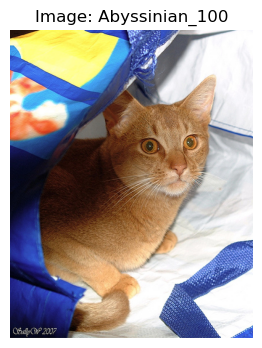

In [20]:
# trainval_raw_list 에서 예제 이미지 불러오기
show_image_with_bboxs(trainval_raw_list[0], image_dir)

In [21]:
# XML 파일 이름 가져오기 (확장자 제거)
xml_list_from_files = [os.path.splitext(file)[0] for file in os.listdir(xml_dir) if file.endswith(".xml")]

# Train 이미지에 대해 XML 파일이 없는 경우 확인
missing_xml_from_trainval = [image for image in trainval_raw_list if image not in xml_list_from_files]

# Train 이미지에 대해 XML 파일이 있는 경우만 리스트에 포함
trainval_list = [image for image in trainval_raw_list if image in xml_list_from_files]

# 결과 출력
print(f"XML 파일이 없는 Train 이미지 수: {len(missing_xml_from_trainval)}")
print(missing_xml_from_trainval)
print(f"Trainval 이미지 수: {len(trainval_list)}")

XML 파일이 없는 Train 이미지 수: 9
['Abyssinian_104', 'Bengal_111', 'samoyed_10', 'Bengal_175', 'Egyptian_Mau_14', 'Egyptian_Mau_156', 'Egyptian_Mau_186', 'Ragdoll_199', 'saint_bernard_15']
Trainval 이미지 수: 3671


## Test 데이터 이미지 확인

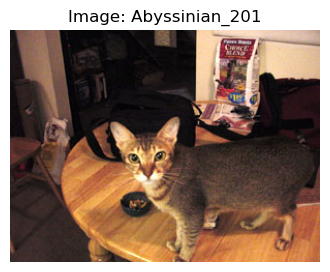

In [22]:
# Test 데이터에서 예제 이미지 불러오기
show_image_with_bboxs(test_raw_list[0], image_dir)

## XML 파일 정리

In [23]:
# 예제 XML 파일 경로
example_xml_file = os.path.join(xml_dir, xml_files[0])
print(example_xml_file)

# XML 파일 읽기 및 파싱
tree = ET.parse(example_xml_file)
root = tree.getroot()

# 재귀적으로 모든 태그와 데이터 출력 함수
def print_all_elements(element, indent=""):
    print(f"{indent}{element.tag}: {element.text}")
    for child in element:
        print_all_elements(child, indent + "  ")

# XML 구조 탐색
print_all_elements(root)

C:/Users/User/Google Drive 스트리밍/내 드라이브/Colab Notebooks/코드잇스프린트자료/미션/미션DATA/미션7DATA\annotations\annotations\xmls\Abyssinian_114.xml
annotation: None
  folder: OXIIIT
  filename: Abyssinian_114.jpg
  source: None
    database: OXFORD-IIIT Pet Dataset
    annotation: OXIIIT
    image: flickr
  size: None
    width: 640
    height: 423
    depth: 3
  segmented: 0
  object: None
    name: cat
    pose: Frontal
    truncated: 0
    occluded: 0
    bndbox: None
      xmin: 222
      ymin: 64
      xmax: 351
      ymax: 185
    difficult: 0


In [24]:
for obj in root.findall("object"):
    class_name = obj.find("name").text  # 클래스 이름
    bndbox = obj.find("bndbox")
    x_min = int(bndbox.find("xmin").text)
    y_min = int(bndbox.find("ymin").text)
    x_max = int(bndbox.find("xmax").text)
    y_max = int(bndbox.find("ymax").text)
    print(f"Class: {class_name}, Bounding Box: ({x_min}, {y_min}, {x_max}, {y_max})")

Class: cat, Bounding Box: (222, 64, 351, 185)


In [25]:
print(f"Train/val 이미지 수: {len(trainval_list)}")
print(f"Test 이미지 수: {len(test_raw_list)}")

Train/val 이미지 수: 3671
Test 이미지 수: 3669


In [26]:
# 모든 XML 파일 처리
annotations = []

for xml_file in xml_files:
    xml_path = os.path.join(xml_dir, xml_file)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    image_name = root.find("filename").text  # 이미지 파일 이름

    for obj in root.findall("object"):
        class_name = obj.find("name").text
        bndbox = obj.find("bndbox")
        x_min = int(bndbox.find("xmin").text)
        y_min = int(bndbox.find("ymin").text)
        x_max = int(bndbox.find("xmax").text)
        y_max = int(bndbox.find("ymax").text)

        annotations.append({
            "image": image_name,
            "class": class_name,
            "bbox": [x_min, y_min, x_max, y_max]
        })

In [27]:
# 확인용 df
df_annotations = pd.DataFrame(annotations)
df_annotations

,image,class,bbox
0,Abyssinian_114.jpg,cat,"[222, 64, 351, 185]"
1,Abyssinian_116.jpg,cat,"[71, 43, 249, 190]"
2,Abyssinian_110.jpg,cat,"[25, 8, 175, 162]"
3,Abyssinian_11.jpg,cat,"[43, 57, 94, 105]"
4,Abyssinian_112.jpg,cat,"[112, 17, 433, 340]"
...,...,...,...
3682,yorkshire_terrier_117.jpg,dog,"[83, 1, 225, 148]"
3683,yorkshire_terrier_10.jpg,dog,"[70, 59, 256, 228]"
3684,yorkshire_terrier_100.jpg,dog,"[159, 2, 419, 230]"
3685,yorkshire_terrier_101.jpg,dog,"[26, 1, 373, 305]"


In [28]:
df_annotations.describe()

,image,class,bbox
count,3687,3687,3687
unique,3686,2,3687
top,Bengal_105.jpg,dog,"[222, 64, 351, 185]"
freq,2,2498,1


- 중복 항목 확인

In [29]:
df_annotations[df_annotations.duplicated('image')]

,image,class,bbox
505,Bengal_105.jpg,cat,"[397, 103, 451, 132]"


In [30]:
df_annotations[df_annotations['image']=='Bengal_105.jpg']

,image,class,bbox
504,Bengal_105.jpg,cat,"[49, 125, 111, 168]"
505,Bengal_105.jpg,cat,"[397, 103, 451, 132]"


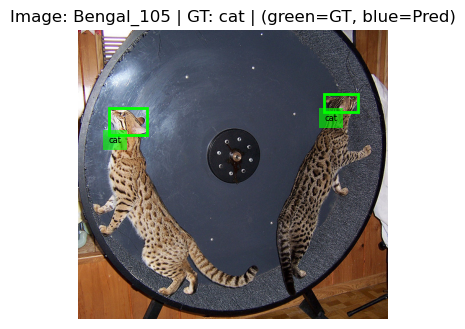

In [31]:
show_image_with_bboxs('Bengal_105', image_dir, df_annotations)

- 실제 고양이 얼굴 2개라 문제 없어 보임

In [32]:
(df_annotations["image"].map(lambda x: Path(str(x)).stem) == "Bengal_105").sum()

2

In [33]:
df_annotations.loc[df_annotations["image"].map(lambda x: Path(str(x)).stem)=="Bengal_105", "bbox"].head()

504     [49, 125, 111, 168]
505    [397, 103, 451, 132]
Name: bbox, dtype: object

In [34]:
df_annotations['class'].value_counts()

class
dog    2498
cat    1189
Name: count, dtype: int64

# 2. 데이터 전처리

### 데이터 증강 전략
- 좌우 대칭 이미지 -> 수평 뒤집기 처리
- 색/밝기 변형 -> 얼굴 탐지
- 입력 크기 통일 (320) -> SSDLite(MobileNetV3) 이용 예정

#### 데이터셋 클래스

- num_workers 오류 해결을 위해 PetFaceDataset.py로 임포트

#### Transforms 클래스

- num_workers 오류 해결을 위해 PetFaceDataset.py로 임포트

In [35]:
train_tf = SSDAugment(320, train=True, p_flip=0.6, p_color=0.8, p_zoom=0.25) # 박스 포함, H플립, 약한V플립, 랜덤 컬러 변형, 줌인 크롭
valtest_tf = SSDAugment(320, train=False)

- train : val = 8 : 2 분할 처리 및 데이터셋 구성
- 이미지리스트 -> df에 필터링 -> train/val 데이터셋 설정

In [36]:
# 환경에 따라 배치 사이즈 변경
if check_google_colab:
    BATCH_SIZE = 64
else:
    BATCH_SIZE = 32

In [37]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [39]:
trainval_list = sorted(trainval_list)  # 정렬
shuffle(trainval_list)

total_size = len(trainval_list)
train_size = int(total_size * 0.8)
val_size = total_size - train_size

# 이미지 리스트
train_list = trainval_list[:train_size]
val_list = trainval_list[train_size:]
test_list = test_raw_list

# df 분할
train_wanted = set(train_list)
train_mask = df_annotations["image"].map(lambda x: Path(str(x)).stem).isin(train_wanted)
df_annotations_train = df_annotations[train_mask].copy()

val_wanted = set(val_list)
val_mask = df_annotations["image"].map(lambda x: Path(str(x)).stem).isin(val_wanted)
df_annotations_val = df_annotations[val_mask].copy()

# ds 설정
image_dir_local = str(DST)
train_ds = PetFaceDataset(df_annotations_train, image_dir_local, train_list, train_tf)
val_ds   = PetFaceDataset(df_annotations_val,   image_dir_local, val_list,   valtest_tf)

test_ds = TestImageDataset(image_dir, test_list, valtest_tf)

# dl 설정
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_pairlist,
                    num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=1, worker_init_fn=worker_init_fn, timeout=0,)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_pairlist,
                    num_workers=4, pin_memory=True, persistent_workers=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_pairlist,
                     num_workers=4, pin_memory=True, persistent_workers=True)

print(f"Train 이미지 데이터 수: {len(train_list)} | 데이터셋: {len(train_ds)}")
print(f"Validation 이미지 데이터 수: {len(val_list)} | 데이터셋: {len(val_ds)}")
print(f"Test 이미지 데이터 수: {len(test_list)} | 데이터셋: {len(test_ds)}")

Train 이미지 데이터 수: 2936 | 데이터셋: 2936
Validation 이미지 데이터 수: 735 | 데이터셋: 735
Test 이미지 데이터 수: 3669 | 데이터셋: 3669


# 3. 모델링
- 모델 구성(SSDLite320 + MobileNetV3, COCO 사전학습 → 배경, 고양이, 강아지 3클래스로 헤드 교체)

In [40]:
num_classes = 3  # background(0), cat(1), dog(2)

weights = SSDLite320_MobileNet_V3_Large_Weights.COCO_V1
model = ssdlite320_mobilenet_v3_large(weights=weights)

blocks = getattr(model.head.classification_head, "module_list",
                 list(model.head.classification_head.children()))

in_channels = []
for b in blocks:
    first_conv = next((c for c in b.modules() if isinstance(c, nn.Conv2d)), None)
    assert first_conv is not None, "헤드 블록에서 Conv2d를 찾지 못했습니다."
    in_channels.append(first_conv.in_channels)

num_anchors = model.anchor_generator.num_anchors_per_location()

new_head = SSDLiteClassificationHead(
    in_channels=in_channels,
    num_anchors=num_anchors,
    num_classes=num_classes,
    norm_layer=nn.BatchNorm2d,
)
model.head.classification_head = new_head

blocks_after = getattr(model.head.classification_head, "module_list",
                       list(model.head.classification_head.children()))
for i, b in enumerate(blocks_after):
    last_conv = None
    for c in b.modules():
        if isinstance(c, nn.Conv2d):
            last_conv = c
    assert last_conv is not None
    expected = num_anchors[i] * num_classes
    assert last_conv.out_channels == expected, f"head[{i}] out={last_conv.out_channels}, expected={expected}"

model = model.to(device)
print("classification head rebuilt for 3 classes")

classification head rebuilt for 3 classes


# 4. 학습 루프

In [41]:
# 환경에 따라 최대 에폭 사이즈 변경
if check_google_colab:
    EPOCHS = 64
else:
    EPOCHS = 32

MIN_EPOCHS = 5
WARMUP_EPOCHS = 3

- 학습 검증용 `mAP50` 메소드

In [42]:
@torch.no_grad()
def compute_map_50(model, data_loader, device, iou_thr=0.5, score_thr=0.0, nms_iou=0.55):
    model.eval()
    classes = (1, 2)
    ap_list = []

    for c in classes:
        scores, tp, fp = [], [], []
        n_gt = 0

        for images, targets in tqdm(data_loader, leave=False):
            images = [img.to(device) for img in images]
            outs = model(images)

            for out, tgt in zip(outs, targets):
                # GT: 해당 클래스만
                gt = tgt["boxes"][tgt["labels"] == c].to(device)
                n_gt += gt.size(0)

                # 예측 후처리: 점수필터 + (클래스별) NMS
                post = postprocess_single(out, score_thr=score_thr, nms_iou=nms_iou, per_class_nms=True)

                # Pred: 해당 클래스만
                mask = (post["labels"] == c)
                pred_boxes  = post["boxes"][mask].to(device)
                pred_scores = post["scores"][mask].to(device)

                if pred_scores.numel():
                    order = torch.argsort(pred_scores, descending=True)
                    pred_boxes  = pred_boxes[order]
                    pred_scores = pred_scores[order]

                matched = torch.zeros(len(gt), dtype=torch.bool, device=device)

                for pb, sc in zip(pred_boxes, pred_scores):
                    if gt.numel() == 0:
                        scores.append(float(sc)); tp.append(0); fp.append(1); continue
                    ious = box_iou(pb.unsqueeze(0), gt).squeeze(0)
                    miou, midx = ious.max(0)
                    if miou >= iou_thr and not matched[midx]:
                        matched[midx] = True
                        scores.append(float(sc)); tp.append(1); fp.append(0)
                    else:
                        scores.append(float(sc)); tp.append(0); fp.append(1)

        if not scores:
            ap_list.append(0.0)
            continue

        s = np.array(scores)
        order = np.argsort(-s)
        tpc = np.array(tp)[order]
        fpc = np.array(fp)[order]
        tpc_cum = np.cumsum(tpc)
        fpc_cum = np.cumsum(fpc)
        recalls = tpc_cum / max(n_gt, 1)
        precisions = tpc_cum / np.maximum(tpc_cum + fpc_cum, 1e-9)

        ap = 0.0
        for t in np.linspace(0, 1, 11):
            p = precisions[recalls >= t].max() if np.any(recalls >= t) else 0.0
            ap += p / 11.0
        ap_list.append(float(ap))

    return float(np.mean(ap_list))

- COCO 스타일 mAP 메소드 (최종 검증용)

In [43]:
@torch.no_grad()
def compute_map_coco_style(model, data_loader, device, score_thr=0.0, nms_iou=0.55):
    ious = np.arange(0.50, 0.95 + 1e-9, 0.05)
    ap_per_iou = []
    ap_detail = {}
    for thr in ious:
        ap = compute_map_50(
            model, data_loader, device,
            iou_thr=float(thr), score_thr=score_thr, nms_iou=nms_iou
        )
        ap_per_iou.append(ap)
        ap_detail[f"{thr:.2f}"] = float(ap)
    coco_map = float(np.mean(ap_per_iou))
    return coco_map, ap_detail

- 얼리스탑 메소드

In [44]:
class EarlyStoppingMax:
    def __init__(self, patience=5, min_delta=2e-3):
        self.patience = patience
        self.min_delta = float(min_delta)
        self.best = None
        self.wait = 0
        self.should_stop = False

    def step(self, current):
        if self.best is None or current > self.best + self.min_delta:
            self.best = current
            self.wait = 0
            return False  # continue
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.should_stop = True
            return self.should_stop

- 학습 진행
- AdmW 옵티마이저 적용
- OneCycleLR 스케쥴러 적용
- 얼리 스탑 적용

In [45]:
optimizer = AdamW([p for p in model.parameters() if p.requires_grad], lr=3e-4, weight_decay=1e-4)

epochs = EPOCHS
steps_per_epoch = len(train_dl)
scheduler = OneCycleLR(optimizer, max_lr=3e-4, total_steps=epochs*steps_per_epoch,
                       pct_start=0.1, anneal_strategy='cos')

def move_target_to_device(t, device):
    need = ("boxes", "labels", "image_id")
    out = {}
    for k, v in t.items():
        if k in need and torch.is_tensor(v):
            out[k] = v.to(device)
        else:
            out[k] = v
    return out

best_map = -1.0
best_state = None
early = EarlyStoppingMax(patience=5, min_delta=0.002)

for epoch in range(epochs):
    model.train()
    running = 0.0

    for images, targets in tqdm(train_dl, leave=False):
        images  = [img.to(device) for img in images]
        targets = [move_target_to_device(t, device) for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        scheduler.step()

        running += loss.item()

    train_loss = running / max(len(train_dl), 1)

    model.eval()
    with torch.no_grad():
        map50 = compute_map_50(model, val_dl, device, iou_thr=0.5, score_thr=0.0)

    tqdm.write(f"Epoch {epoch+1}/{epochs} | train_loss: {train_loss:.4f} | val mAP@0.5: {map50:.4f}")

    # 체크포인트(베스트 갱신 시)
    if map50 > best_map:
        best_map = map50
        best_state = deepcopy(model.state_dict())
        torch.save(best_state, "best_ssd.pt")
#        print("Saved best: best_ssd.pt")

    # 얼리 스탑 체크(mAP 기준)
    if early.step(map50):
        tqdm.write(f"Early stopping at epoch {epoch+1} (best mAP@0.5={early.best:.4f})")
        break

# 학습 종료 후 베스트 로드
if best_state is not None:
    model.load_state_dict(best_state)

  0%|          | 0/92 [00:10<?, ?it/s]

  0%|          | 0/23 [00:10<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 1/32 | train_loss: 8.3344 | val mAP@0.5: 0.1629


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 2/32 | train_loss: 3.6785 | val mAP@0.5: 0.8599


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 3/32 | train_loss: 2.1211 | val mAP@0.5: 0.8962


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 4/32 | train_loss: 1.6951 | val mAP@0.5: 0.9028


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 5/32 | train_loss: 1.4478 | val mAP@0.5: 0.9066


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 6/32 | train_loss: 1.3120 | val mAP@0.5: 0.9062


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 7/32 | train_loss: 1.2020 | val mAP@0.5: 0.9095


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 8/32 | train_loss: 1.1447 | val mAP@0.5: 0.9082


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 9/32 | train_loss: 1.0640 | val mAP@0.5: 0.9080


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 10/32 | train_loss: 1.0155 | val mAP@0.5: 0.9070


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 11/32 | train_loss: 0.9616 | val mAP@0.5: 0.9089


  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 12/32 | train_loss: 0.9189 | val mAP@0.5: 0.9084
Early stopping at epoch 12 (best mAP@0.5=0.9095)


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

- 학습 최종 검증 `mAP@0.5:0.95`

In [46]:
# === 최종 평가: mAP@0.50 + COCO mAP@[.50:.95] ===
map50_final = compute_map_50(model, val_dl, device, iou_thr=0.50, score_thr=0.0, nms_iou=0.55)
coco_map, ap_grid = compute_map_coco_style(model, val_dl, device, score_thr=0.0, nms_iou=0.55)

print("\n===== Final Validation Metrics =====")
print(f"mAP@0.50          : {map50_final:.4f}")
print(f"mAP@[.50:.95] (COCO): {coco_map:.4f}")

# IoU별 AP 표로 보기
try:
    df_ap = pd.DataFrame({"IoU": list(ap_grid.keys()), "AP": list(ap_grid.values())})
    df_ap = df_ap.sort_values("IoU")
    print("\nAP by IoU threshold")
    print(df_ap.to_string(index=False))
except Exception:
    print("\nAP by IoU:", ap_grid)


===== Final Validation Metrics =====
mAP@0.50          : 0.9095
mAP@[.50:.95] (COCO): 0.7079

AP by IoU threshold
 IoU       AP
0.50 0.909507
0.55 0.902628
0.60 0.899739
0.65 0.897669
0.70 0.890216
0.75 0.838581
0.80 0.807429
0.85 0.622430
0.90 0.292752
0.95 0.018275


- 모델 검증: val
- val 이미지 셋에서 랜덤하게 이미지 검증

In [47]:
@torch.no_grad()
def show_val_sample(model, val_loader, device, df_annotations, image_dir,
                    score_thr=0.4, n=5, class_names=None, seed=None):
    model.eval()
    ds = val_loader.dataset

    # 무작위 인덱스 선택
    rng = random.Random(seed)
    n = min(n, len(ds))
    idxs = rng.sample(range(len(ds)), k=n)

    for idx in idxs:
        # 1) 단일 샘플 불러오기
        img, tgt = ds[idx]
        img_in = img.to(device).unsqueeze(0)  # (1,C,H,W)

        out = model(img_in)[0]

        out_pp = postprocess_single(out, score_thr=score_thr, nms_iou=0.55, per_class_nms=True)

        # 3) 원본 좌표계로 박스 복원
        H0, W0 = map(int, tgt["orig_size"].tolist())
        H1, W1 = map(int, tgt["resize_size"].tolist())
        sx, sy = W0 / max(W1, 1), H0 / max(H1, 1)

        boxes = out_pp["boxes"].detach().cpu().clone()
        if boxes.numel() > 0:
            scale = torch.tensor([sx, sy, sx, sy], dtype=boxes.dtype)
            boxes = boxes * scale

        pred_vis = {
            "boxes": boxes,
            "scores": out_pp["scores"].detach().cpu(),
            "labels": out_pp["labels"].detach().cpu(),
        }

        stem = Path(tgt.get("path", "")).stem
        if not stem:  # 혹시 대비
            it = ds.items[idx]
            stem = Path(it["path"]).stem if isinstance(it, dict) and "path" in it else Path(it).stem

        show_image_with_bboxs(
            imageFileName=stem,
            image_dir=image_dir,
            df_annotations=df_annotations,
            pred=pred_vis,
            class_names=class_names,
            score_thr=score_thr,
        )

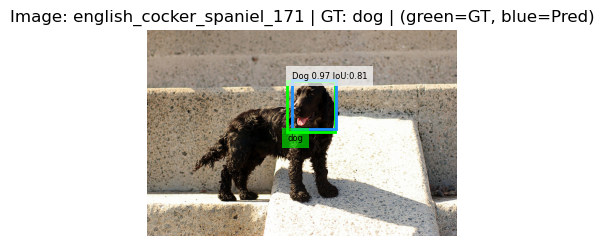

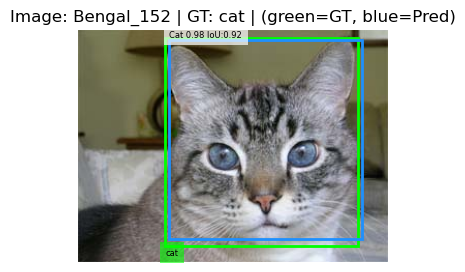

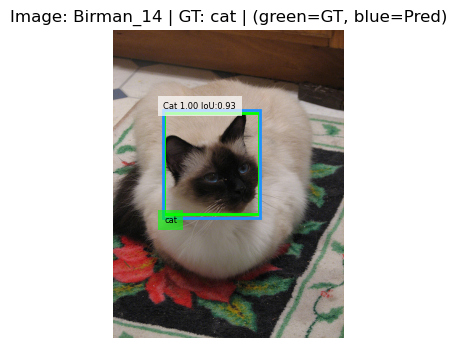

In [48]:
show_val_sample(
    model, val_dl, device,
    df_annotations=df_annotations_val,
    image_dir=image_dir,
    score_thr=0.65,
    n=3,                 # 원하는 표시 개수
    class_names=CLASS_NAMES,
    seed=None
)

- 모델 검증: test
- test 이미지 셋에서 랜덤하게 이미지 검증

In [49]:
@torch.no_grad()
def show_test_sample(model, test_loader, device, image_dir, score_thr=0.4, n=10, class_names=None, seed=None):
    model.eval()
    shown = 0
    ds = test_loader.dataset

    # 1) 무작위 인덱스 선택
    rng = random.Random(seed)
    n = min(n, len(ds))
    idxs = rng.sample(range(len(ds)), k=n)

    for idx in idxs:
        img, tgt = ds[idx]
        out_raw = model(img.to(device).unsqueeze(0))[0]

        out_pp = postprocess_single(out_raw, score_thr=score_thr, nms_iou=0.55, per_class_nms=True)

        H0, W0 = map(int, tgt["orig_size"].tolist())
        H1, W1 = map(int, tgt["resize_size"].tolist())
        sx, sy = W0 / max(W1, 1), H0 / max(H1, 1)

        boxes = out_pp["boxes"].detach().cpu().clone()
        if boxes.numel() > 0:
            scale = torch.tensor([sx, sy, sx, sy], dtype=boxes.dtype)
            boxes = boxes * scale

        pred_vis = {
            "boxes": boxes,
            "scores": out_pp["scores"].detach().cpu(),
            "labels": out_pp["labels"].detach().cpu(),
        }

        stem = Path(tgt.get("path", "")).stem or Path(ds.items[idx]).stem

        show_image_with_bboxs(
            imageFileName=stem,
            image_dir=image_dir,
            df_annotations=None,
            pred=pred_vis,
            class_names=class_names,
            score_thr=score_thr
        )

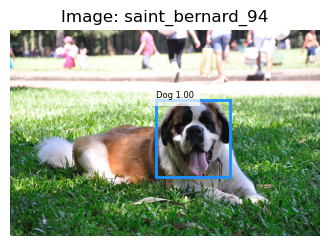

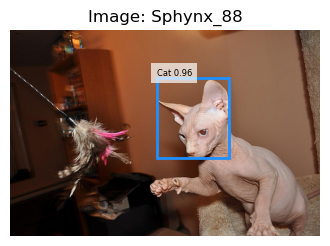

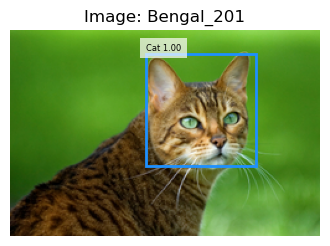

In [50]:
show_test_sample(model, test_dl, device,
                image_dir=image_dir,
                score_thr=0.6,
                n=3,
                class_names=CLASS_NAMES)

- 이미지 파일명으로 지정 확인

In [51]:
@torch.no_grad()
def run_single_image(model, device, image_name, image_dir,
                     score_thr=0.4, class_names=None, size=320, nms_iou=0.55):
    model.eval()

    # 1) 경로 구성 (+ 확장자 보정)
    name = str(image_name)
    if not Path(name).suffix:   # 확장자 없으면 .jpg 가정
        name = f"{name}.jpg"
    p = Path(image_dir) / name
    if not p.exists():
        raise FileNotFoundError(f"이미지를 찾을 수 없습니다: {p}")

    # 2) 이미지 로드 (원본 보존용 크기 기록)
    data = np.fromfile(str(p), dtype=np.uint8)
    img_bgr = cv2.imdecode(data, cv2.IMREAD_COLOR)
    if img_bgr is None:
        raise FileNotFoundError(f"이미지 로딩 실패: {p}")
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(img)
    H0, W0 = img.shape[:2]

    # 3) 전처리 (SSDAugment(train=False)과 동일)
    pil_resized = F.resize(pil, (size, size))
    x = F.to_tensor(pil_resized)
    x = F.normalize(x, mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
    x = x.to(device).unsqueeze(0)  # (1,C,H,W)

    # 4) 추론
    out_raw = model(x)[0]

    # 5) 후처리(NMS) - 있으면 사용, 없으면 점수 필터만
    if "postprocess_single" in globals():
        post = postprocess_single(out_raw, score_thr=score_thr,
                                  nms_iou=nms_iou, per_class_nms=True)
        boxes  = post["boxes"].detach().cpu().clone()
        scores = post["scores"].detach().cpu().clone()
        labels = post["labels"].detach().cpu().clone()
    else:
        keep = out_raw["scores"].detach().cpu() >= float(score_thr)
        boxes  = out_raw["boxes"].detach().cpu().clone()[keep]
        scores = out_raw["scores"].detach().cpu().clone()[keep]
        labels = out_raw["labels"].detach().cpu().clone()[keep]

    # 6) 원본 좌표계로 복원
    if boxes.numel() > 0:
        sx, sy = W0 / float(size), H0 / float(size)
        scale = torch.tensor([sx, sy, sx, sy], dtype=boxes.dtype)
        boxes = boxes * scale

    pred_vis = {"boxes": boxes, "scores": scores, "labels": labels}

    print("pred labels:", pred_vis["labels"].cpu().tolist())
    print("pred scores:", [round(s,2) for s in pred_vis["scores"].cpu().tolist()])

    # 7) 시각화
    show_image_with_bboxs(
        imageFileName=Path(p).stem,     # 파일명(확장자 제거)
        image_dir=str(p.parent),        # 실제 폴더 경로
        df_annotations=None,
        pred=pred_vis,
        class_names=class_names,
        score_thr=score_thr
    )

pred labels: [2]
pred scores: [0.98]


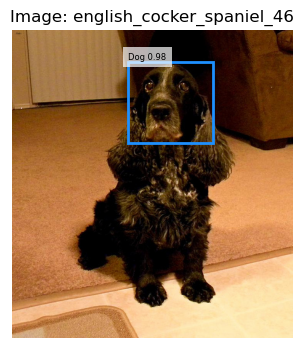

In [53]:
run_single_image(
    model, device,
    image_name="english_cocker_spaniel_46",
    image_dir=image_dir,
    score_thr=0.75,
    class_names=CLASS_NAMES
)

- 스프린트 커뮤니티(디스코드) 채널 동물방에 올라온 이미지로 확인

pred labels: [2]
pred scores: [0.95]


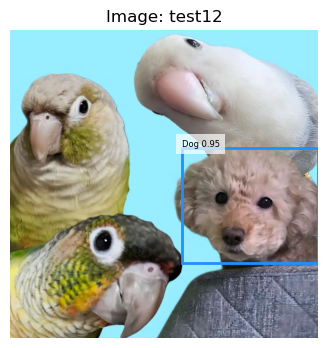

In [64]:
run_single_image(
    model, device,
    image_name="test12",
    image_dir="C:\\Users\\User\\Documents\\infeim\\Codeit_AI4\\DATA\\mission7_images",       # 테스트 이미지 폴더
    score_thr=0.65,
    class_names=CLASS_NAMES
)

# 5. 결과 요약

### 모델 구성
- SSDLite320 + MobileNetV3
- COCO 사전학습 가중치 활용

- 헤드 교체: 배경 / 고양이 / 강아지 (3클래스)

### 핵심 성능
- 베스트 성능: `mAP@0.50` = 0.9095 (에폭 7)
- 얼리스탑: 에폭 12에서 정지(개선 정체) → 베스트 가중치 로드

COCO mAP: `mAP@0.50:0.95` = 0.7079

- 평가 설정(최종): NMS IoU=0.55, score_thr=0.0 (전수 랭킹 기반 평가)

### 학습/검증 추이
- 초기 급상승: 0.1629 → 0.8599(에폭 2) → 0.9066(에폭 5)
- 플래토: 에폭 7에서 0.9095 도달 이후 0.907~0.909 구간에서 정체

- 손실 감소: train_loss 8.33 → 0.92(에폭 12)로 꾸준히 하락 (OneCycleLR 정상 동작)

### IoU별 AP
|IoU	|AP|
|-------|----:|
|0.50	|0.910|
|0.55	|0.903|
|0.60	|0.900|
|**0.65**	|**0.898**|
|0.70	|0.890|
|0.75	|0.839|
|0.80	|0.807|
|0.85	|0.622|
|0.90	|0.293|
|0.95	|0.018|

### 해석
- **낮은 IoU(0.50~0.70)** 에선 탐지·분류 강함
- **높은 IoU(≥0.85)** 에서 급격한 하락 → 바운딩 박스 정밀도(로컬라이제이션) 개선 여지

- 즉, AP50 ↗ / AP75·85·90 ↘ 패턴 → “박스 위치가 대체로는 맞지만 정확도가 부족”

### 진단
- 수렴 속도: 빠르게 수렴, 얼리스탑 적절히 작동
- 병목: 로컬라이제이션 품질(고 IoU 구간)

여유가 있었다면 학습용 이미지 증강과 바운딩 박스(디폴트 박스) 튜닝에 리소스를 더 투입했으면 성능 향상을 기대할 수 있었습니다.